In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Load the dataset
df = pd.read_parquet('../data/processed_openmoji_dataset.parquet')
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

# Custom Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]['combined_embedding']).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]['image_path']).float()
        return embedding, image_tensor

# Create DataLoader
dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


"""
Reference: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
Learning ConvTranspose2d layers for upsampling
"""
# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()
        
        # Compute the starting spatial size dynamically
        self.init_size = 32 // 4  # If final image is 32x32, init_size should be 8x8
        
        self.noise_fc = nn.Sequential(
            nn.Linear(noise_dim, 256 * self.init_size * self.init_size),
            nn.ReLU(),
        )
        self.embed_fc = nn.Sequential(
            nn.Linear(embedding_dim, 256 * self.init_size * self.init_size),
            nn.ReLU(),
        )
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, noise, embed):
        noise_features = self.noise_fc(noise).view(noise.size(0), 256, self.init_size, self.init_size)
        embed_features = self.embed_fc(embed).view(embed.size(0), 256, self.init_size, self.init_size)
        
        # x = torch.cat((noise_features, embed_features), dim=1)
        x = noise_features + embed_features
        # x = self.fc(x).view(x.size(0), 256, 4, 4)
        x = self.conv_blocks(x)
        return x


"""
Reference: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
Learning Conv2d layers for downsampling
"""
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, image_channels=3):
        super(Discriminator, self).__init__()
        self.embed_fc = nn.Linear(embedding_dim, 32 * 32)  # Directly match image size
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(image_channels + 1, 64, kernel_size=4, stride=2, padding=1), # added +1
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to weaken discriminator
            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to weaken discriminator
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to weaken discriminator
        )
        # self.fc = nn.Linear(256 * 4 * 4 + embedding_dim, 1)
        self.fc = nn.Linear(256 * 8 * 8, 1)
        # Project embedding into a spatial format
        # self.embed_fc = nn.Linear(embedding_dim, 8 * 8)  # Map embeddings to 4x4 spatial size
        
    def forward(self, img, embed):
        # Convert embedding into spatial form
        embed_features = self.embed_fc(embed).view(img.size(0), 1, img.shape[2], img.shape[3])
        # Concatenate embeddings as an extra channel
        x = torch.cat((img, embed_features), dim=1)  # (batch, image_channels + 1, H, W)
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)  # Flatten
        return torch.sigmoid(self.fc(x))

# Model Initialization
noise_dim = 100
embedding_dim = len(df['combined_embedding'][0])
generator = Generator(noise_dim, embedding_dim).to(device)
discriminator = Discriminator(embedding_dim).to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))


num_epochs = 5000
d_losses, g_losses, d_fake_conf, d_real_conf = [], [], [], []

# Initialize fixed noise once before training loop
fixed_noise = torch.zeros(40, noise_dim).to(device)  # This remains constant throughout training

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for combined_embeddings, real_images in progress_bar:
        combined_embeddings = combined_embeddings.to(device)
        real_images = real_images.to(device)
        
        # Train Discriminator
        noise = torch.randn(real_images.size(0), noise_dim).to(device)
        fake_images = generator(noise, combined_embeddings)
        
        real_labels = torch.full((real_images.size(0), 1), 0.9).to(device)
        fake_labels = torch.full((real_images.size(0), 1), 0.1).to(device)
        
        real_outputs = discriminator(real_images, combined_embeddings)
        fake_outputs = discriminator(fake_images.detach(), combined_embeddings)
        
        # Discriminator confidence
        real_confidence = real_outputs.mean().item()
        fake_confidence = fake_outputs.mean().item()
        
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        fake_outputs = discriminator(fake_images, combined_embeddings)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    # Store loss values
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    d_fake_conf.append(fake_confidence)
    d_real_conf.append(real_confidence)

    # Using tqdm.write() for clean logging
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Real Confidence: {real_confidence:.4f} | D Fake Confidence: {fake_confidence:.4f} | G Loss: {g_loss.item():.4f}")

    # Visualization every 25 epochs
    if (epoch + 1) % 25 == 0:
        with torch.no_grad():
            random_noise = torch.randn(40, noise_dim).to(device)
            
            sample_embeddings, real_images = next(iter(dataloader))
            real_count = min(40, real_images.shape[0])  # Ensure we don't slice out of bounds

            real_images = real_images[:real_count].cpu()
            sample_embeddings = sample_embeddings[:real_count].to(device)

            generated_fixed = generator(fixed_noise[:real_count], sample_embeddings).cpu()
            generated_random = generator(random_noise[:real_count], sample_embeddings).cpu()
        
        
        print(f"real_images.shape: {real_images.shape}")
        print(f"generated_fixed.shape: {generated_fixed.shape}")
        print(f"generated_random.shape: {generated_random.shape}")
        # Concatenate images for visualization: Real | Fixed | Random
        all_images = torch.cat((real_images, generated_fixed, generated_random), dim=0)
        
        # Display Grid (Real on top, Fixed in middle, Random at bottom)
        grid = make_grid(all_images, nrow=10, normalize=True)

        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Real (Top) | Fixed Noise (Middle) | Random Noise (Bottom) - Epoch {epoch+1}')
        plt.show()

        # Plot Loss Chart
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(d_real_conf) + 1), d_real_conf, label="D Real Confidence")
        plt.plot(range(1, len(d_fake_conf) + 1), d_fake_conf, label="D Fake Confidence")
        plt.plot(range(1, len(g_losses) + 1), g_losses, label="G Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Loss Over Time")
        plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Load the dataset
df = pd.read_parquet('../data/processed_openmoji_dataset.parquet')
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

# Custom Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]['combined_embedding']).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]['image_path']).float()
        return embedding, image_tensor

# Create DataLoader
dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


"""
Reference: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
Learning ConvTranspose2d layers for upsampling
"""
# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()
        self.noise_fc = nn.Sequential(
            nn.Linear(noise_dim, 256 * 4 * 4),
            nn.ReLU(),
        )
        self.embed_fc = nn.Sequential(
            nn.Linear(embedding_dim, 256 * 4 * 4),
            nn.ReLU(),
        )
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, noise, embed):
        noise_features = self.noise_fc(noise).view(noise.size(0), 256, 4, 4)
        embed_features = self.embed_fc(embed).view(embed.size(0), 256, 4, 4)
        
        # x = torch.cat((noise_features, embed_features), dim=1)
        x = noise_features + embed_features
        # x = self.fc(x).view(x.size(0), 256, 4, 4)
        x = self.conv_blocks(x)
        return x


"""
Reference: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
Learning Conv2d layers for downsampling
"""
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, image_channels=3):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(image_channels + 1, 64, kernel_size=4, stride=2, padding=1), # added +1
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to weaken discriminator
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to weaken discriminator
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to weaken discriminator
        )
        # self.fc = nn.Linear(256 * 4 * 4 + embedding_dim, 1)
        self.fc = nn.Linear(256 * 4 * 4, 1)
        # Project embedding into a spatial format
        self.embed_fc = nn.Linear(embedding_dim, 4 * 4)  # Map embeddings to 4x4 spatial size
        
    def forward(self, img, embed):
        batch_size = img.size(0)
        # Convert embedding into spatial form
        embed_features = self.embed_fc(embed).view(batch_size, 1, 4, 4)  # Shape: (batch, 1, 4, 4)
        # Resize embedding map to match image dimensions (expand)
        embed_features = torch.nn.functional.interpolate(embed_features, size=(img.shape[2], img.shape[3]))
        # Concatenate embeddings as an extra channel
        x = torch.cat((img, embed_features), dim=1)  # (batch, image_channels + 1, H, W)
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)  # Flatten
        return torch.sigmoid(self.fc(x))
        
        # x = self.conv_blocks(img)
        # x = x.view(x.size(0), -1)
        # x = torch.cat((x, embed), dim=1)
        # return torch.sigmoid(self.fc(x))

# Model Initialization
noise_dim = 100
embedding_dim = len(df['combined_embedding'][0])
generator = Generator(noise_dim, embedding_dim).to(device)
discriminator = Discriminator(embedding_dim).to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))


num_epochs = 1000
d_losses, g_losses, d_fake_conf, d_real_conf = [], [], [], []

# Initialize fixed noise once before training loop
fixed_noise = torch.zeros(40, noise_dim).to(device)  # This remains constant throughout training

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for combined_embeddings, real_images in progress_bar:
        combined_embeddings = combined_embeddings.to(device)
        real_images = real_images.to(device)
        
        # Train Discriminator
        noise = torch.randn(real_images.size(0), noise_dim).to(device)
        fake_images = generator(noise, combined_embeddings)
        
        real_labels = torch.full((real_images.size(0), 1), 0.9).to(device)
        fake_labels = torch.full((real_images.size(0), 1), 0.1).to(device)
        
        real_outputs = discriminator(real_images, combined_embeddings)
        fake_outputs = discriminator(fake_images.detach(), combined_embeddings)
        
        # Discriminator confidence
        real_confidence = real_outputs.mean().item()
        fake_confidence = fake_outputs.mean().item()
        
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        fake_outputs = discriminator(fake_images, combined_embeddings)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    # Store loss values
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    d_fake_conf.append(fake_confidence)
    d_real_conf.append(real_confidence)

    # Using tqdm.write() for clean logging
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Real Confidence: {real_confidence:.4f} | D Fake Confidence: {fake_confidence:.4f} | G Loss: {g_loss.item():.4f}")

    # Visualization every 25 epochs
    if (epoch + 1) % 25 == 0:
        with torch.no_grad():
            random_noise = torch.randn(40, noise_dim).to(device)
            
            sample_embeddings, real_images = next(iter(dataloader))
            real_count = min(40, real_images.shape[0])  # Ensure we don't slice out of bounds

            real_images = real_images[:real_count].cpu()
            sample_embeddings = sample_embeddings[:real_count].to(device)

            generated_fixed = generator(fixed_noise[:real_count], sample_embeddings).cpu()
            generated_random = generator(random_noise[:real_count], sample_embeddings).cpu()

        # Concatenate images for visualization: Real | Fixed | Random
        all_images = torch.cat((real_images, generated_fixed, generated_random), dim=0)
        
        # Display Grid (Real on top, Fixed in middle, Random at bottom)
        grid = make_grid(all_images, nrow=10, normalize=True)

        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Real (Top) | Fixed Noise (Middle) | Random Noise (Bottom) - Epoch {epoch+1}')
        plt.show()

        # Plot Loss Chart
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(d_real_conf) + 1), d_real_conf, label="D Real Confidence")
        plt.plot(range(1, len(d_fake_conf) + 1), d_fake_conf, label="D Fake Confidence")
        plt.plot(range(1, len(g_losses) + 1), g_losses, label="G Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Loss Over Time")
        plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Load the dataset
df = pd.read_parquet('../data/processed_openmoji_dataset.parquet')
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]['combined_embedding']).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]['image_path']).float()
        return embedding, image_tensor

dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + embedding_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, noise, embed):
        x = torch.cat((noise, embed), dim=1).unsqueeze(2).unsqueeze(3)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, embedding_dim, image_channels=3):
        super(Discriminator, self).__init__()
        self.embed_layer = nn.Linear(embedding_dim, 32 * 32)  # Convert embedding to a 32x32 map

        self.main = nn.Sequential(
            nn.Conv2d(image_channels + 1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 8, 1, 0, bias=False), # Adjusted 4 to 8
            nn.Sigmoid()
        )
    
    def forward(self, img, embed):
        embed = self.embed_layer(embed)  # Convert embedding to (batch, 1024)
        embed = embed.view(embed.shape[0], 1, 32, 32)  # Reshape to (batch, 1, 32, 32)
        
        x = torch.cat((img, embed), dim=1)  # Concatenate along channel dimension
        return self.main(x).view(-1, 1)

noise_dim = 100
embedding_dim = len(df['combined_embedding'][0])
generator = Generator(noise_dim, embedding_dim).to(device)
discriminator = Discriminator(embedding_dim).to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=5e-5, betas=(0.5, 0.999)) # Lower LR for D
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

d_losses, g_losses, d_fake_conf, d_real_conf = [], [], [], []
num_epochs = 1000

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for combined_embeddings, real_images in progress_bar:
        combined_embeddings = combined_embeddings.to(device)
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        real_labels = torch.full((batch_size, 1), 0.9, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size, 1), 0.1, dtype=torch.float, device=device)
        
        # Train Discriminator
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise, combined_embeddings)
        
        real_outputs = discriminator(real_images, combined_embeddings)
        fake_outputs = discriminator(fake_images.detach(), combined_embeddings)
        
        # Discriminator confidence
        real_confidence = real_outputs.mean().item()
        fake_confidence = fake_outputs.mean().item()
        
        d_loss = criterion(real_outputs, real_labels) + criterion(fake_outputs, fake_labels)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        fake_outputs = discriminator(fake_images, combined_embeddings)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    d_fake_conf.append(fake_confidence)
    d_real_conf.append(real_confidence)
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Real Confidence: {real_confidence:.4f} | D Fake Confidence: {fake_confidence:.4f} | G Loss: {g_loss.item():.4f}")
        
    if (epoch + 1) % 25 == 0:
        with torch.no_grad():
            noise = torch.randn(40, noise_dim).to(device)
            
            # Get real embeddings and real images from the dataset
            sample_embeddings, _ = next(iter(dataloader))  
            sample_embeddings = sample_embeddings[:40].to(device)  # Take the first 64 embeddings
            real_images = real_images[:40].cpu()  # Take the first 64 real images
            
            # Generate emojis
            generated_images = generator(noise, sample_embeddings).cpu()
        
        # Concatenate real and generated images
        all_images = torch.cat((real_images, generated_images), dim=0)  # Stack along batch dimension
        
        # Display Grid (Real on top, Generated below)
        grid = make_grid(all_images, nrow=8, normalize=True)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Real (Top) vs. Generated (Bottom) Emojis - Epoch {epoch+1}')
        plt.show()

        # Plot Loss Chart
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(d_real_conf) + 1), d_real_conf, label="D Real Confidence")
        plt.plot(range(1, len(d_fake_conf) + 1), d_fake_conf, label="D Fake Confidence")
        plt.plot(range(1, len(g_losses) + 1), g_losses, label="G Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Loss Over Time")
        plt.show()


Embedding Consistency Test (Does the generator map embeddings to stable outputs?)

In [ ]:
with torch.no_grad():
    sample_embeddings, real_images = next(iter(dataloader))  
    sample_embeddings = sample_embeddings[:40].to(device)  
    real_images = real_images[:40].cpu()  

    # Generate emojis WITHOUT noise
    noise = torch.zeros((40, noise_dim)).to(device)  # Zero noise for consistency
    generated_images = generator(noise, sample_embeddings).cpu()

# Visualize
grid = make_grid(torch.cat((real_images, generated_images), dim=0), nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Real (Top) vs. Generated (Bottom) - No Noise Test")
plt.show()

Noise Sensitivity Test (Does noise introduce meaningful variations?)

In [ ]:
with torch.no_grad():
    sample_embeddings, real_images = next(iter(dataloader))  
    sample_embeddings = sample_embeddings[:40].to(device)  

    # Generate with different noise inputs
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))  # 3 different noise tests
    for i in range(3):  
        noise = torch.randn(40, noise_dim).to(device)  # Different noise each time
        generated_images = generator(noise, sample_embeddings).cpu()

        grid = make_grid(generated_images, nrow=8, normalize=True)
        axes[i].imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        axes[i].axis("off")
        axes[i].set_title(f"Generated Emojis - Noise Sample {i+1}")

    plt.show()

Latent Space Interpolation Test (Are embeddings smoothly mapped to outputs?)

In [ ]:
with torch.no_grad():
    # Pick two embeddings
    sample_embeddings, _ = next(iter(dataloader))  
    e1, e2 = sample_embeddings[:1].to(device), sample_embeddings[1:2].to(device)  # (1, embedding_dim)

    # Interpolate embeddings (10 steps)
    alpha_vals = torch.linspace(0, 1, steps=10).to(device)  # 10 interpolation points
    interpolated_embeddings = torch.stack([torch.lerp(e1, e2, alpha) for alpha in alpha_vals]).squeeze(1)

    # Generate images for interpolated embeddings
    noise = torch.zeros((10, noise_dim)).to(device)  # No noise for consistency
    generated_images = generator(noise, interpolated_embeddings).cpu()

# Visualize
grid = make_grid(generated_images, nrow=10, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Latent Space Interpolation - Smooth Transition?")
plt.show()

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Use GPU if available
"""
Reference: https://pytorch.org/get-started/locally/
"""

# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using Mac GPU (MPS)


In [15]:
# Load the dataset
df = pd.read_parquet('../data/processed_openmoji_dataset.parquet')

# Convert combined_embedding to float32 numpy array
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

# Custom Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]['combined_embedding']).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]['image_path']).float()
        
        return embedding, image_tensor

# Create DataLoader
dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [16]:
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_channels * 32 * 32),
            nn.Tanh()
        )

    def forward(self, noise, embed):
        x = torch.cat((noise, embed), dim=1)
        x = self.model(x)
        return x.view(x.size(0), 3, 32, 32)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, image_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_channels * 32 * 32 + embedding_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, embed):
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, embed), dim=1)
        return self.model(x)

In [18]:
noise_dim = 100  # Dimension of noise vector
embedding_dim = len(df['combined_embedding'][0])  # Length of SBERT embedding

# Initialize Generator and Discriminator
generator = Generator(noise_dim, embedding_dim).to(device)
discriminator = Discriminator(embedding_dim).to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [ ]:
num_epochs = 500
d_losses, g_losses, d_fake_losses, d_real_losses = [], [], [], []

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for combined_embeddings, real_images in progress_bar:
        combined_embeddings = combined_embeddings.to(device)
        real_images = real_images.to(device)
        
        # Train Discriminator
        noise = torch.randn(real_images.size(0), noise_dim).to(device)
        fake_images = generator(noise, combined_embeddings)
        
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        
        real_outputs = discriminator(real_images, combined_embeddings)
        fake_outputs = discriminator(fake_images.detach(), combined_embeddings)
        
        # Discriminator confidence
        real_confidence = real_outputs.mean().item()
        fake_confidence = fake_outputs.mean().item()
        
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        fake_outputs = discriminator(fake_images, combined_embeddings)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    # Store loss values
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    d_fake_losses.append(fake_confidence)
    d_real_losses.append(real_confidence)

    # Using tqdm.write() for clean logging
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Display 64 generated emojis and loss chart every 25 epochs
    if (epoch + 1) % 25 == 0:
        with torch.no_grad():
            noise = torch.randn(40, noise_dim).to(device)
            
            # Get real embeddings and real images from the dataset
            sample_embeddings, _ = next(iter(dataloader))  
            sample_embeddings = sample_embeddings[:40].to(device)  # Take the first 64 embeddings
            real_images = real_images[:40].cpu()  # Take the first 64 real images
            
            # Generate emojis
            generated_images = generator(noise, sample_embeddings).cpu()
        
        # Concatenate real and generated images
        all_images = torch.cat((real_images, generated_images), dim=0)  # Stack along batch dimension
        
        # Display Grid (Real on top, Generated below)
        grid = make_grid(all_images, nrow=8, normalize=True)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Real (Top) vs. Generated (Bottom) Emojis - Epoch {epoch+1}')
        plt.show()

        # Plot Loss Chart
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(d_real_losses) + 1), d_real_losses, label="D Loss Real")
        plt.plot(range(1, len(d_fake_losses) + 1), d_fake_losses, label="D Loss Fake")
        plt.plot(range(1, len(g_losses) + 1), g_losses, label="G Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Loss Over Time")
        plt.show()

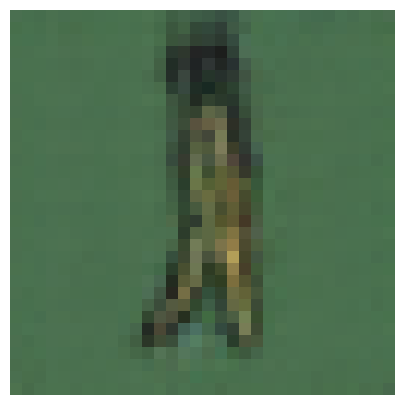

In [27]:
# Loading the same SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Sample prompt text
sample_text = "happy face with heart eyes"
sample_embedding = sbert_model.encode([sample_text], convert_to_tensor=True)
sample_embedding = sample_embedding.float().to(device)

def generate_emoji(generator, embedding, num_samples=1):
    generator.eval()  # Set to evaluation mode
    noise = torch.randn(num_samples, noise_dim).to(device)  # Random noise for generation

    with torch.no_grad():
        generated_images = generator(noise, embedding)
    generated_images = generated_images.cpu() * 0.5 + 0.5  # Denormalize

    return generated_images

import matplotlib.pyplot as plt

def visualize_generated_emoji(generated_images):
    num_samples = generated_images.size(0)
    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, img in enumerate(generated_images):
        axes[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from Tensor format
        axes[i].axis('off')
    plt.show()

# Generate and visualize the emoji
generated_emoji = generate_emoji(generator, sample_embedding)
visualize_generated_emoji(generated_emoji)